# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [2]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (649/649), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 649 (delta 363), reused 599 (delta 347), pack-reused 0
Receiving objects: 100% (649/649), 2.40 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (363/363), done.
/content/ast
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12

## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper.

In [3]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'
import timm
from timm.models.layers import to_2tuple,trunc_normal_
import torchaudio.transforms as T

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x, classifier=True):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        if classifier:
            x = self.mlp_head(x)
        return x

if __name__ == '__main__':
    input_tdim = 100
    ast_mdl = ASTModel(input_tdim=input_tdim)
    # input a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
    test_input = torch.rand([10, input_tdim, 128])
    test_output = ast_mdl(test_input)
    # output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
    print(test_output.shape)

    # input_tdim = 256
    # ast_mdl = ASTModel(input_tdim=input_tdim,label_dim=50, audioset_pretrain=True)
    # # input a batch of 10 spectrogram, each with 512 time frames and 128 frequency bins
    # test_input = torch.rand([10, input_tdim, 128])
    # test_output = ast_mdl(test_input)
    # # output should be in shape [10, 50], i.e., 10 samples, each with prediction of 50 classes.
    # print(test_output.shape)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth" to ../../pretrained_models/hub/checkpoints/deit_base_distilled_patch16_384-d0272ac0.pth


frequncey stride=10, time stride=10
number of patches=108
torch.Size([10, 527])


In [4]:
# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    # assert sr == 16000, 'input audio sampling rate must be 16kHz'
    resample_rate = 16000
    resampler = T.Resample(sr, resample_rate, dtype=waveform.dtype)
    resampled_waveform = resampler(waveform)
    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(
                      # label_dim=527,
                      input_tdim=input_tdim, imagenet_pretrain=True,
                      # audioset_pretrain=False
                      )
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
# audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

# Load the AudioSet label set
label_csv = '/content/ast/egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction):

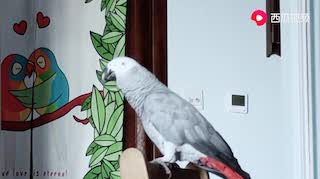

Replace the `sample_audio_path` to test your own audio.

In [5]:
# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

if os.path.exists('/content/ast/sample_audios') == False:
  os.mkdir('/content/ast/sample_audios')
if os.path.exists('/content/ast/sample_audios/sample_audio.flac') == True:
  os.remove('/content/ast/sample_audios/sample_audio.flac')
wget.download(sample_audio_path, '/content/ast/sample_audios/sample_audio.flac')
# add more technique ex. audio cutting
feats = make_features('/content/ast/sample_audios/sample_audio.flac', mel_bins=128)           # shape(1024, 128)
print(type(feats))
# only feature extraction
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data, classifier = False)
    print(output.shape)
    output = torch.sigmoid(output)
    print(output.shape)
# result_output = output.data.cpu().numpy()[0]
# sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
# print('Predice results:')
# for k in range(10):
#     print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
# print('Listen to this sample: ')
# IPython.display.Audio('/content/ast/sample_audios/sample_audio.flac')

<class 'torch.Tensor'>
torch.Size([1, 768])
torch.Size([1, 768])


# load ESC50

In [6]:
!git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136
Receiving objects: 100% (4199/4199), 878.79 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


In [7]:
import os
sound_list = os.listdir("/content/ast/ESC-50/audio/")

In [8]:
def extract_features(sound_sample_path):
    with torch.no_grad():
        feats = make_features(sound_sample_path, mel_bins=128)           # shape(1024, 128)
        # only feature extraction
        feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
        feats_data = feats_data.to(torch.device("cuda:0"))
        with autocast():
            output = audio_model.forward(feats_data, classifier = False)
    return output

In [9]:
from tqdm import tqdm
precessed_data = []
for i in tqdm(sound_list):
  feats_data = extract_features("/content/ast/ESC-50/audio/"+i)
  precessed_data.append(feats_data)

100%|██████████| 2000/2000 [01:37<00:00, 20.47it/s]


In [10]:
extracted_feature = np.array([i.cpu() for i in precessed_data])

In [11]:
extracted_feature.shape

(2000, 1, 768)

### train test spliting

In [36]:
extracted_feature = extracted_feature.reshape(2000,768)

In [15]:
import pandas as pd
label = pd.read_csv("/content/ast/ESC-50/meta/esc50.csv")

In [16]:
y = [label[label["filename"] == i]["category"].values[0] for i in os.listdir("/content/ast/ESC-50/audio/")]

In [37]:
from sklearn.model_selection import train_test_split

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(extracted_feature, y, test_size=0.25, random_state=42)

# Hyperparameter tuning and training

In [96]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

knn_dict = {"algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
          "p":[1,2]}
rf_dict = {"criterion": ['gini', 'entropy', 'log_loss'],
           "max_depth": [4,8,12,None]}
svm_dict = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}

In [99]:
knn_best = GridSearchCV(KNN(n_neighbors=50), knn_dict,verbose = 4)
rf_best = GridSearchCV(RFC(), rf_dict,verbose = 4)
svc_best = GridSearchCV(SVC(), svm_dict,verbose = 4)

In [100]:
extracted_feature = extracted_feature.reshape(2000,768)

In [102]:
knn_best.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ...............algorithm=auto, p=1;, score=0.497 total time=   0.4s
[CV 2/5] END ...............algorithm=auto, p=1;, score=0.440 total time=   0.4s
[CV 3/5] END ...............algorithm=auto, p=1;, score=0.450 total time=   0.4s
[CV 4/5] END ...............algorithm=auto, p=1;, score=0.430 total time=   0.4s
[CV 5/5] END ...............algorithm=auto, p=1;, score=0.473 total time=   0.4s
[CV 1/5] END ...............algorithm=auto, p=2;, score=0.510 total time=   0.0s
[CV 2/5] END ...............algorithm=auto, p=2;, score=0.433 total time=   0.0s
[CV 3/5] END ...............algorithm=auto, p=2;, score=0.437 total time=   0.0s
[CV 4/5] END ...............algorithm=auto, p=2;, score=0.427 total time=   0.0s
[CV 5/5] END ...............algorithm=auto, p=2;, score=0.463 total time=   0.0s
[CV 1/5] END ..........algorithm=ball_tree, p=1;, score=0.497 total time=   0.6s
[CV 2/5] END ..........algorithm=ball_tree, p=1;,

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=50),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'p': [1, 2]},
             verbose=4)

In [103]:
rf_best.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.447 total time=   1.9s
[CV 2/5] END .......criterion=gini, max_depth=4;, score=0.403 total time=   1.7s
[CV 3/5] END .......criterion=gini, max_depth=4;, score=0.460 total time=   1.7s
[CV 4/5] END .......criterion=gini, max_depth=4;, score=0.433 total time=   1.6s
[CV 5/5] END .......criterion=gini, max_depth=4;, score=0.427 total time=   1.7s
[CV 1/5] END .......criterion=gini, max_depth=8;, score=0.607 total time=   3.2s
[CV 2/5] END .......criterion=gini, max_depth=8;, score=0.553 total time=   3.3s
[CV 3/5] END .......criterion=gini, max_depth=8;, score=0.567 total time=   2.9s
[CV 4/5] END .......criterion=gini, max_depth=8;, score=0.507 total time=   2.9s
[CV 5/5] END .......criterion=gini, max_depth=8;, score=0.583 total time=   3.2s
[CV 1/5] END ......criterion=gini, max_depth=12;, score=0.627 total time=   4.2s
[CV 2/5] END ......criterion=gini, max_depth=12;

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 8, 12, None]},
             verbose=4)

In [104]:
svc_best.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..............C=0.001, gamma=0.001;, score=0.023 total time=   0.6s
[CV 2/5] END ..............C=0.001, gamma=0.001;, score=0.027 total time=   0.7s
[CV 3/5] END ..............C=0.001, gamma=0.001;, score=0.023 total time=   0.7s
[CV 4/5] END ..............C=0.001, gamma=0.001;, score=0.023 total time=   0.7s
[CV 5/5] END ..............C=0.001, gamma=0.001;, score=0.023 total time=   0.7s
[CV 1/5] END ...............C=0.001, gamma=0.01;, score=0.023 total time=   0.7s
[CV 2/5] END ...............C=0.001, gamma=0.01;, score=0.027 total time=   0.7s
[CV 3/5] END ...............C=0.001, gamma=0.01;, score=0.023 total time=   0.6s
[CV 4/5] END ...............C=0.001, gamma=0.01;, score=0.023 total time=   0.7s
[CV 5/5] END ...............C=0.001, gamma=0.01;, score=0.023 total time=   0.7s
[CV 1/5] END ................C=0.001, gamma=0.1;, score=0.023 total time=   0.7s
[CV 2/5] END ................C=0.001, gamma=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             verbose=4)

In [106]:
svc_best.best_estimator_

SVC(C=10, gamma=0.001)

## save best model

In [112]:
# save as object
import joblib

filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/svc_best.pkl"
s = joblib.dump(svc_best.best_estimator_, filename)
filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/rf_best.pkl"
s = joblib.dump(rf_best.best_estimator_, filename)
filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/knn_best.pkl"
s = joblib.dump(knn_best.best_estimator_, filename)

# testing


## load best model

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import joblib

filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/svc_best.pkl"
svc_best = joblib.load(filename)
filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/rf_best.pkl"
rf_best = joblib.load(filename)
filename = "/content/drive/MyDrive/kmutt/2nd years/cpe232  data model/Datamodel Project/knn_best.pkl"
knn_best = joblib.load(filename)

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
def con_mx(X,y,clf,name):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred,labels=clf.classes_)
  ax = sns.heatmap(pd.DataFrame(cm,index=clf.classes_,columns = clf.classes_))
  ax.set_title(name)
  plt.show()

In [64]:
from sklearn.metrics import f1_score

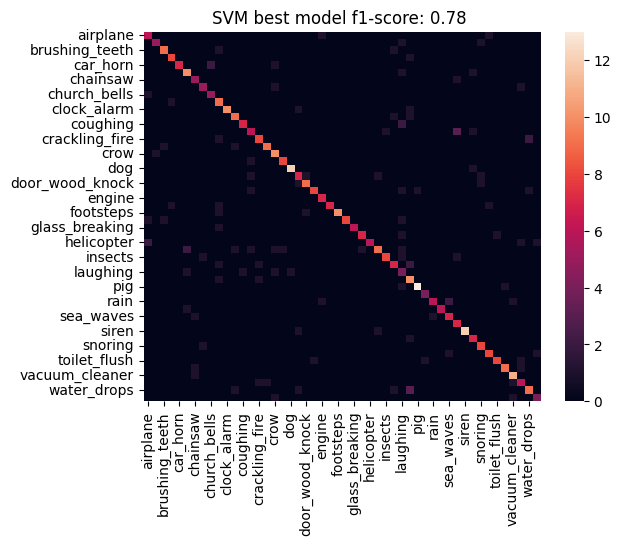

In [70]:
con_mx(X_test,y_test,svc_best,"SVM best model f1-score: {} ".format(round(f1_score(y_test,svc_best.predict(X_test),average='macro'),2)))

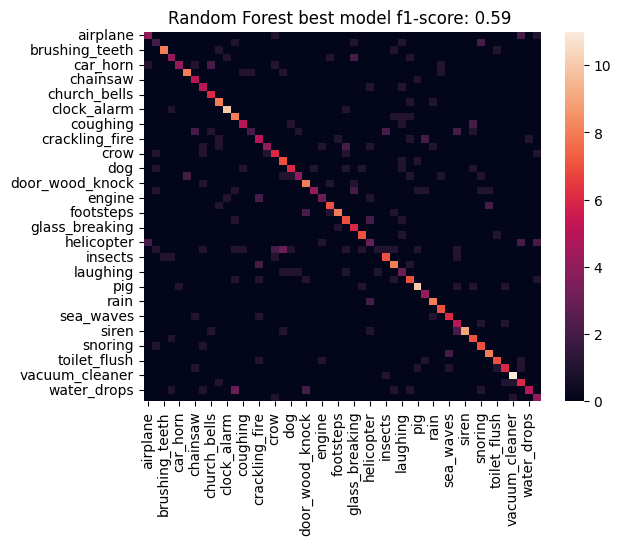

In [72]:
con_mx(X_test,y_test,rf_best,"Random Forest best model f1-score: {} ".format(round(f1_score(y_test,rf_best.predict(X_test),average='macro'),2)))

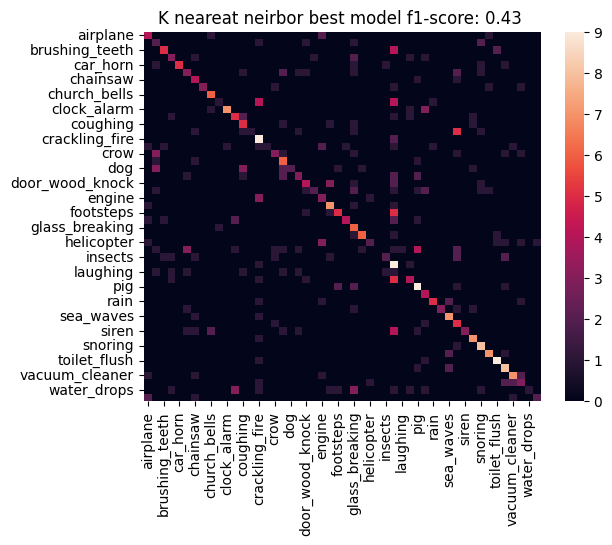

In [73]:
con_mx(X_test,y_test,knn_best,"K neareat neirbor best model f1-score: {} ".format(round(f1_score(y_test,knn_best.predict(X_test),average='macro'),2)))

# Vis layer


## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

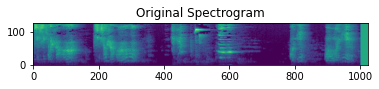

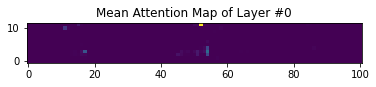

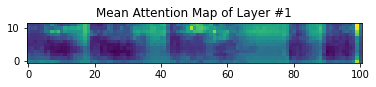

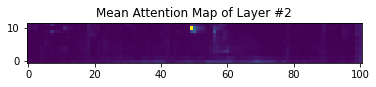

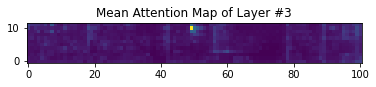

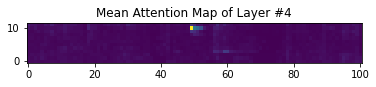

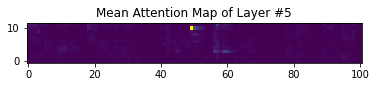

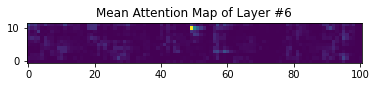

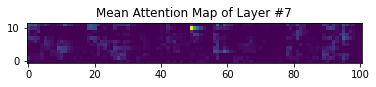

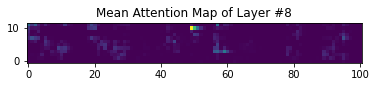

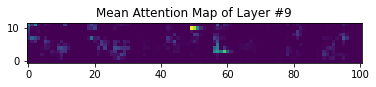

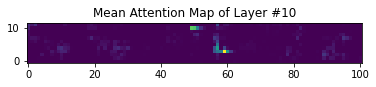

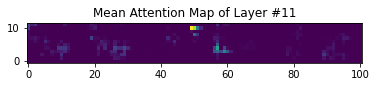

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

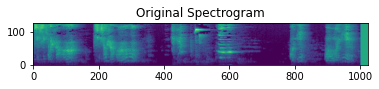

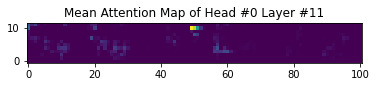

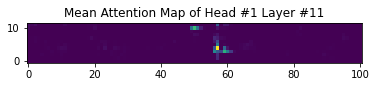

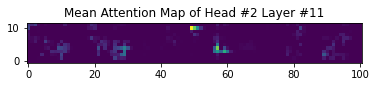

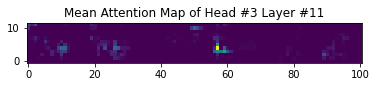

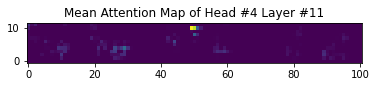

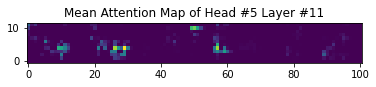

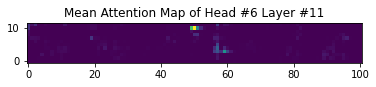

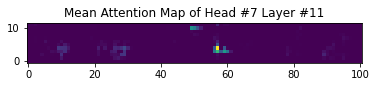

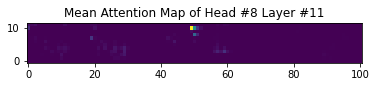

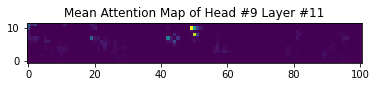

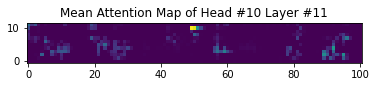

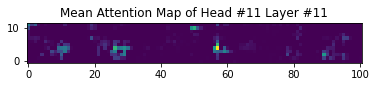

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()